In [1]:
import argparse
import urllib.request, json
import pandas as pd
import geopandas as gpd
import xarray as xr
import odc.aws
from pprint import pprint
from datacube.testutils.io import rio_slurp_xarray
import glob, os
import rasterio
import shutil
import pathlib

In [2]:
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [6]:
#wrs2 = gpd.read_file("D:\data\wrs2_pathrow\wrs2_au_02.shp")

wrs2 = gpd.read_file("D:\data\wrs2_pathrow\WRS2_AU_centroid_buff50m.shp") 

pr = int('110071')

path_row = wrs2[(wrs2['WRSPR'] == pr)]
bbox = list(path_row.total_bounds)
print (bbox)

[123.36171702042158, -15.862167433038866, 123.50229797819127, -15.721585986214468]


In [27]:
#product = 'ga_ls5t_ard_3'
#product = 'ga_ls7e_ard_3'
#product = 'ga_ls8c_ard_3'
product = 'ga_ls9c_ard_3'

start_time = '2023-10-26'
end_time = '2023-10-27'
bbox = bbox

In [28]:
root_url = 'https://explorer.dea.ga.gov.au/stac'
stac_url = f'{root_url}/search?collection={product}&time={start_time}/{end_time}&bbox={str(bbox).replace(" ", "")}&limit=80'
print(stac_url)

https://explorer.dea.ga.gov.au/stac/search?collection=ga_ls9c_ard_3&time=2023-10-26/2023-10-27&bbox=[145.1825326635072,-15.90345172178434,145.18346465094592,-15.902548034056128]&limit=80


In [29]:
with urllib.request.urlopen(stac_url) as url:
    data = json.loads(url.read().decode())
pprint(data, depth=1)

{'context': {...},
 'features': [...],
 'links': [...],
 'numberMatched': 1,
 'numberReturned': 1,
 'type': 'FeatureCollection'}


<AxesSubplot:>

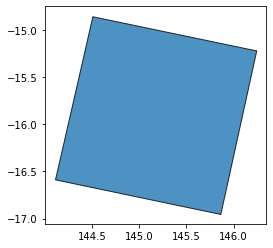

In [30]:
# Convert features to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data['features'])

# Plot the footprints of each dataset
gdf.plot(alpha=0.8, edgecolor='black')

<AxesSubplot:>

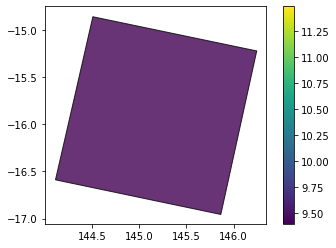

In [31]:
# Colour features by cloud cover
gdf.plot(column='eo:cloud_cover',
         cmap='viridis',
         alpha=0.8,
         edgecolor='black',
         legend=True)

In [32]:
gdf

,geometry,title,gsd,created,gqa:abs_x,gqa:abs_y,gqa:cep90,proj:epsg,fmask:snow,gqa:abs_xy,...,gqa:iterative_stddev_xy,gqa:abs_iterative_mean_x,gqa:abs_iterative_mean_y,landsat:landsat_scene_id,gqa:abs_iterative_mean_xy,landsat:collection_number,landsat:landsat_product_id,landsat:collection_category,cubedash:region_code,datetime
0,"POLYGON ((144.11698 -16.58636, 144.11153 -16.5...",ga_ls9c_ard_3-2-1_096071_2023-10-26_final,15.0,2023-11-05T10:32:47.045000Z,0.23,0.34,0.49,32655,0.0,0.41,...,0.26,0.14,0.24,LC90960712023299LGN00,0.27,2,LC09_L1TP_096071_20231026_20231026_02_T1,T1,096071,2023-10-26T00:22:25.046569Z


In [33]:
cl = gdf[(gdf['eo:cloud_cover'] < 40)]

In [34]:
cl.index
#select =[0]

Int64Index([0], dtype='int64')

index: 0  Image: ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_thumbnail.jpg


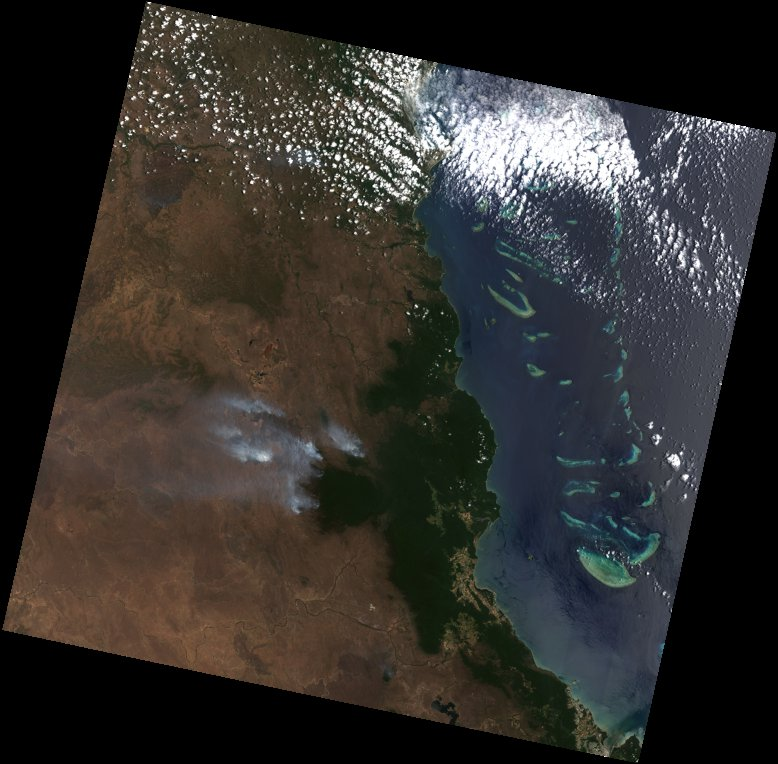

In [35]:
from IPython.display import Image

for i in cl.index:
    
    stac_item = data['features'][i]

    url = stac_item['assets']['thumbnail:nbart']['href']
    jpg = odc.aws.s3_download(url)
    print ('index:',i ,' Image:', jpg)
    display(Image(filename=jpg,width = 800, height = 800))
    os.remove(jpg) 

In [36]:
select = [0]

In [37]:
cd D:\data\working\lzolre_p096r071_d2022111620231026_dlwm5

D:\data\working\lzolre_p096r071_d2022111620231026_dlwm5


In [38]:
# if true dowload the slected bands
#bands = ['nbart_blue','nbart_green','nbart_red','nbart_nir_1']

bands = ['nbart_coastal_aerosol','nbart_blue','nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2']

for i in select:#cl.index:
    
    stac_item = data['features'][i]
    urls = [asset['href'] for asset in stac_item['assets'].values()]
    
    # make a directory to save the current S2 image into
    image_dir = (str(cl['title'][i]))
       
    os.makedirs(image_dir)
    os.chdir(image_dir)
    print (os.getcwd())
        
    for band in bands:
        url = stac_item['assets'][band]['href']
        odc.aws.s3_download(url)
        
    file_list = []
    
    for file in glob.glob("*.tif"):
        print (file)
        file_list.append(file)
    
    comp_file_name = file_list[0][:-10] + 'comp.tif'
    
    band_list = file_list

    # Read metadata of first file
    with rasterio.open(band_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count= len(band_list))

    # Read each layer and write it to stack
    with rasterio.open(comp_file_name, 'w', **meta, compress='lzw') as dst:
        for id, layer in enumerate(band_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
                
    for file in band_list:
        os.remove(file) 
    print("Individual bands have been deleted")   

    os.chdir("..")
    print (os.getcwd())

D:\data\working\lzolre_p096r071_d2022111620231026_dlwm5\ga_ls9c_ard_3-2-1_096071_2023-10-26_final
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band01.tif
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band02.tif
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band03.tif
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band04.tif
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band05.tif
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band06.tif
ga_ls9c_nbart_3-2-1_096071_2023-10-26_final_band07.tif
Individual bands have been deleted
D:\data\working\lzolre_p096r071_d2022111620231026_dlwm5


In [ ]:
ls